In [428]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import math
import scipy.stats as stats
import itertools

In [429]:
# Load SAFE stock dataset
df_safe = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='SAFE.JK')
df_safe.set_index('Date', drop=True, inplace=True)
df_safe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-04,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-05,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-06,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-07,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0


In [430]:
# Check datatypes
print(df_safe.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [431]:
# Check missing value
print(df_safe.isnull().sum())

Open         8
High         8
Low          8
Close        8
Adj Close    8
Volume       8
dtype: int64


In [432]:
# Fill missing value using mean imputation
for i in df_safe[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_safe[i].fillna(df_safe[i].mean(), inplace=True)

print(df_safe.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


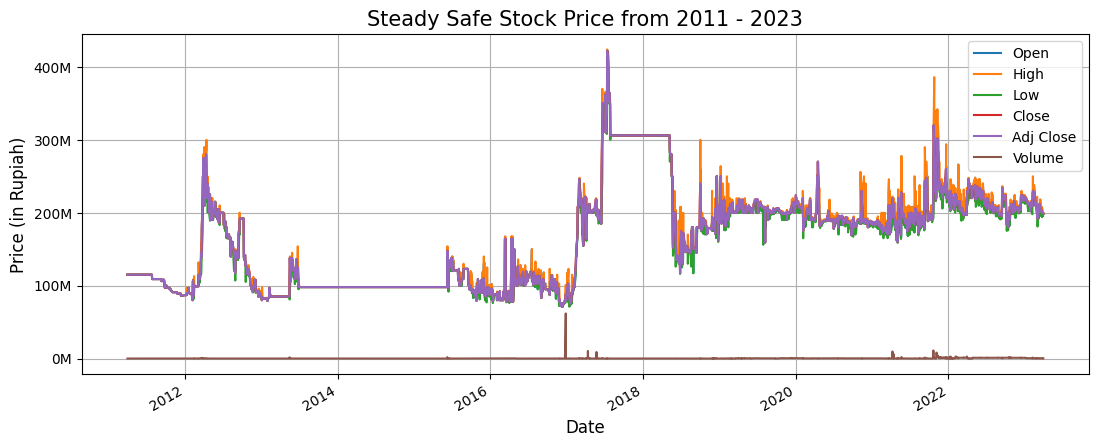

In [433]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_safe.plot(figsize=(13,5))
plt.title('Steady Safe Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [434]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_safe[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [435]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.12535613]
 [0.12535613]
 [0.12535613]
 [0.12535613]
 [0.12535613]] 

Testing Scaled:  [[0.41880342]
 [0.43589744]
 [0.4017094 ]
 [0.42450142]
 [0.42450142]]


In [436]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [437]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 7s 123ms/step - loss: 0.0265 - val_loss: 0.0031
Epoch 2/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 3/10
24/24 [==============================] - 1s 35ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 1s 32ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 5/10
24/24 [==============================] - 1s 33ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 6/10
24/24 [==============================] - 1s 34ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 7/10
24/24 [==============================] - 1s 34ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 8/10
24/24 [==============================] - 1s 33ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 1s 33ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 10/10
24/24 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0024
Model: "

In [438]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 1s 10ms/step
Mean Absolute Error (MAE): 0.0191644
Mean Absolute Percentage Error (MAPE): 0.04884
Root Mean Squared Error (RMSE): 0.02447
Mean Squared Error (MSE): 0.000599
R-Squared (R2): 0.40595
T-Statistic 0.9719
P-Value 0.00011860717495437711
Elapsed Time (min): 14.7


7/7 [==============================] - 0s 10ms/step


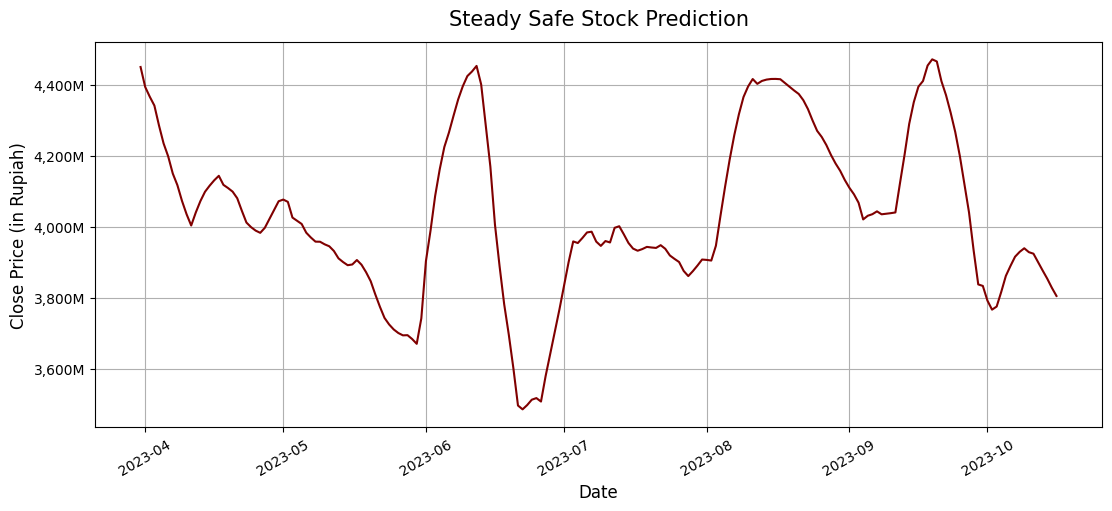

In [439]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [440]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 12s 241ms/step - loss: 0.0158 - val_loss: 0.0031
Epoch 2/10
24/24 [==============================] - 5s 199ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 3/10
24/24 [==============================] - 5s 205ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 4/10
24/24 [==============================] - 5s 202ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 5/10
24/24 [==============================] - 5s 210ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 6/10
24/24 [==============================] - 5s 231ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 5s 219ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0017 - val_loss: 0.002

In [441]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0199288
Mean Absolute Percentage Error (MAPE): 0.05077
Root Mean Squared Error (RMSE): 0.02502
Mean Squared Error (MSE): 0.0006262
R-Squared (R2): 0.378951
T-Statistic 0.9753
P-Value 0.00036566867493093014
Elapsed Time (min): 59.36


7/7 [==============================] - 0s 37ms/step


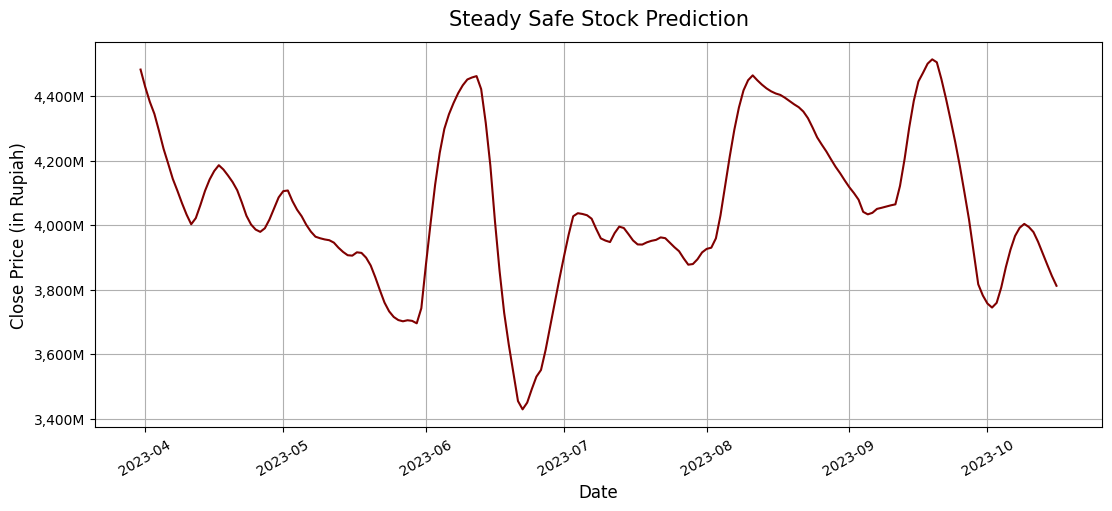

In [442]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [443]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 14s 296ms/step - loss: 0.0680 - val_loss: 0.0567
Epoch 2/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0400 - val_loss: 0.0316
Epoch 3/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0338 - val_loss: 0.0216
Epoch 4/10
24/24 [==============================] - 6s 231ms/step - loss: 0.0303 - val_loss: 0.0172
Epoch 5/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0280 - val_loss: 0.0149
Epoch 6/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0258 - val_loss: 0.0135
Epoch 7/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0247 - val_loss: 0.0125
Epoch 8/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0226 - val_loss: 0.0119
Epoch 9/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0216 - val_loss: 0.0111
Epoch 10/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0196 - val_loss: 0.010

In [444]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0948563
Mean Absolute Percentage Error (MAPE): 0.23246
Root Mean Squared Error (RMSE): 0.09875
Mean Squared Error (MSE): 0.0097508
R-Squared (R2): -8.670196
T-Statistic 0.9504
P-Value 2.9088246833453013e-07
Elapsed Time (min): 69.15


7/7 [==============================] - 0s 38ms/step


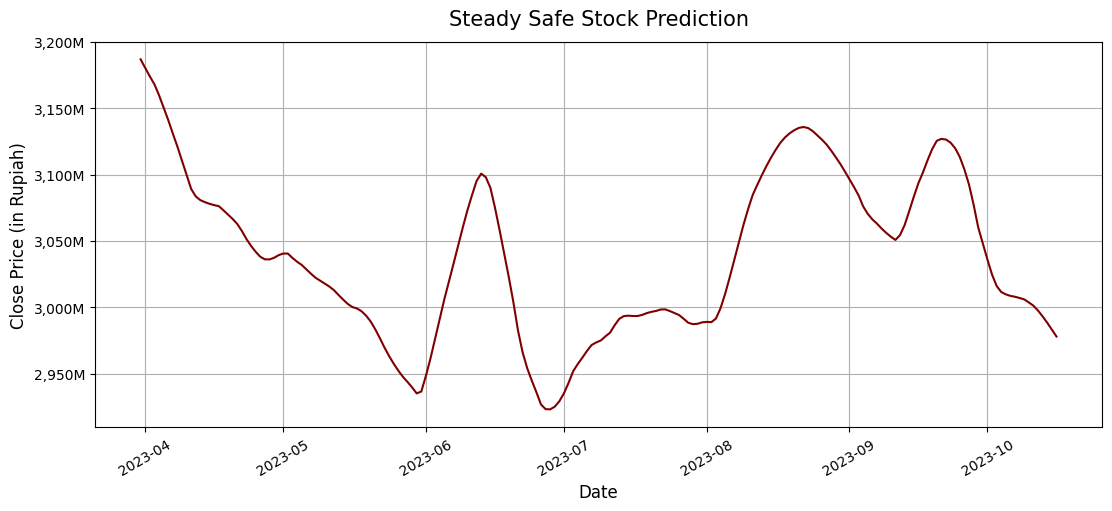

In [445]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [446]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 18s 320ms/step - loss: 0.0168 - val_loss: 0.0032
Epoch 2/10
24/24 [==============================] - 5s 230ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 4/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 10/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0019 - val_loss: 0.002

In [447]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.0211785
Mean Absolute Percentage Error (MAPE): 0.05391
Root Mean Squared Error (RMSE): 0.02594
Mean Squared Error (MSE): 0.0006727
R-Squared (R2): 0.332891
T-Statistic 0.9768
P-Value 0.0006060138694010675
Elapsed Time (min): 72.88


7/7 [==============================] - 0s 43ms/step


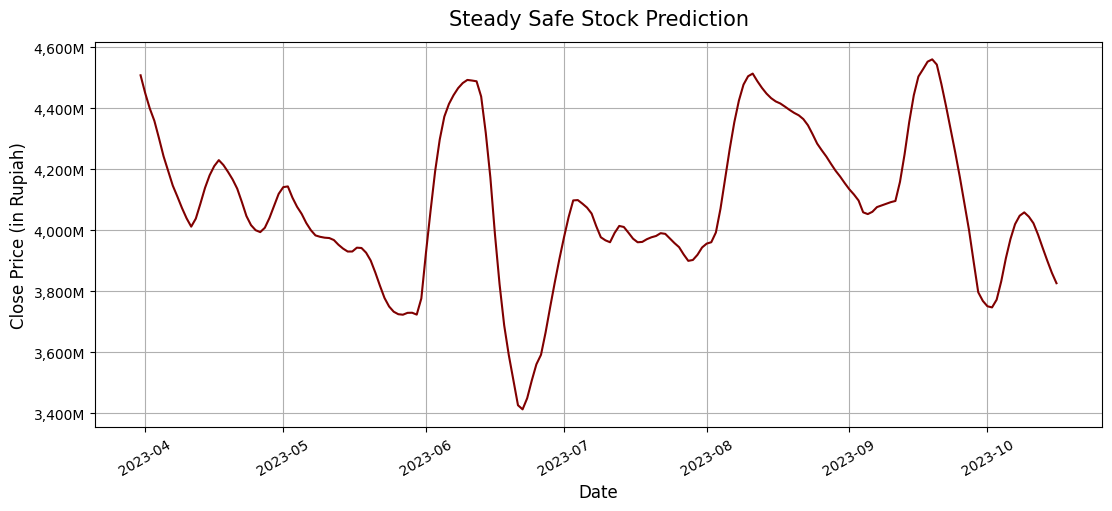

In [448]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [449]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 15s 321ms/step - loss: 0.0113 - val_loss: 0.0078
Epoch 2/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0047 - val_loss: 0.0074
Epoch 3/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 4/10
24/24 [==============================] - 6s 255ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 5/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0030 - val_loss: 0.0079
Epoch 6/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 7/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0023 - val_loss: 0.002

In [450]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 45ms/step
Mean Absolute Error (MAE): 0.0225846
Mean Absolute Percentage Error (MAPE): 0.05784
Root Mean Squared Error (RMSE): 0.02787
Mean Squared Error (MSE): 0.0007769
R-Squared (R2): 0.229568
T-Statistic 0.9722
P-Value 0.00012997073645237833
Elapsed Time (min): 73.28


7/7 [==============================] - 0s 44ms/step


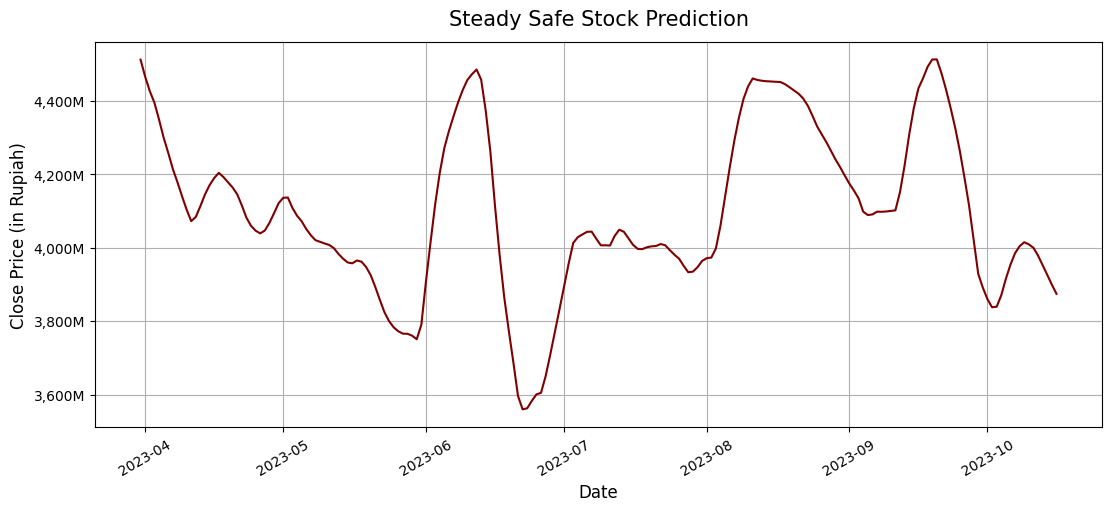

In [451]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [452]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 16s 341ms/step - loss: 0.1075 - val_loss: 0.1570
Epoch 2/10
24/24 [==============================] - 6s 243ms/step - loss: 0.1060 - val_loss: 0.1548
Epoch 3/10
24/24 [==============================] - 6s 256ms/step - loss: 0.1049 - val_loss: 0.1525
Epoch 4/10
24/24 [==============================] - 6s 248ms/step - loss: 0.1030 - val_loss: 0.1503
Epoch 5/10
24/24 [==============================] - 6s 252ms/step - loss: 0.1013 - val_loss: 0.1480
Epoch 6/10
24/24 [==============================] - 6s 251ms/step - loss: 0.1001 - val_loss: 0.1457
Epoch 7/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0983 - val_loss: 0.1433
Epoch 8/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0974 - val_loss: 0.1410
Epoch 9/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0953 - val_loss: 0.1387
Epoch 10/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0935 - val_loss: 0.136

In [453]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.3891133
Mean Absolute Percentage Error (MAPE): 0.96892
Root Mean Squared Error (RMSE): 0.39045
Mean Squared Error (MSE): 0.1524513
R-Squared (R2): -150.19068
T-Statistic 0.9655
P-Value 1.6141981177497655e-05
Elapsed Time (min): 71.65


7/7 [==============================] - 0s 38ms/step


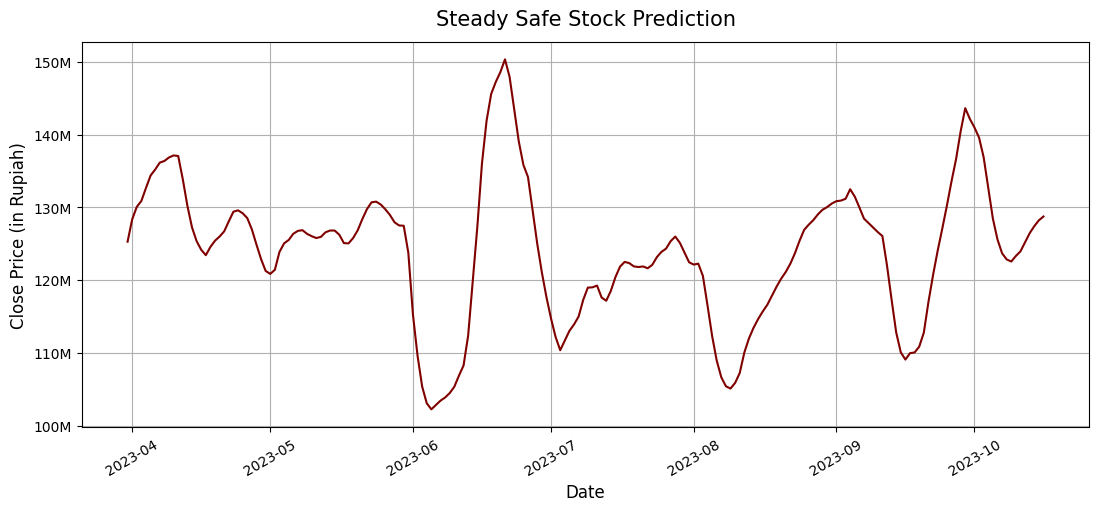

In [454]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [455]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 16s 334ms/step - loss: 0.0431 - val_loss: 0.0173
Epoch 2/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0291 - val_loss: 0.0143
Epoch 3/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0247 - val_loss: 0.0131
Epoch 4/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0206 - val_loss: 0.0102
Epoch 5/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0170 - val_loss: 0.0093
Epoch 6/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0136 - val_loss: 0.0069
Epoch 7/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0111 - val_loss: 0.0062
Epoch 8/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 9/10
24/24 [==============================] - 7s 288ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 10/10
24/24 [==============================] - 8s 313ms/step - loss: 0.0062 - val_loss: 0.004

In [456]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0329282
Mean Absolute Percentage Error (MAPE): 0.07959
Root Mean Squared Error (RMSE): 0.03964
Mean Squared Error (MSE): 0.0015712
R-Squared (R2): -0.558246
T-Statistic 0.9455
P-Value 9.016640944992105e-08
Elapsed Time (min): 76.14


7/7 [==============================] - 0s 39ms/step


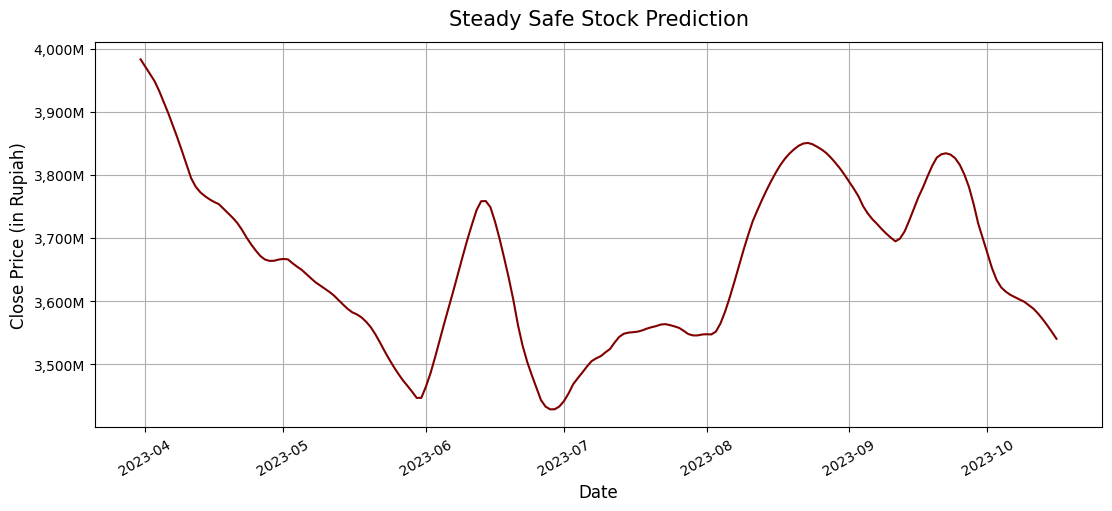

In [457]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [458]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 16s 354ms/step - loss: 0.0161 - val_loss: 0.0030
Epoch 2/10
24/24 [==============================] - 6s 241ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 3/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 5/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 7/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 9/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 10/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0025 - val_loss: 0.002

In [459]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.0183383
Mean Absolute Percentage Error (MAPE): 0.0456
Root Mean Squared Error (RMSE): 0.02538
Mean Squared Error (MSE): 0.0006443
R-Squared (R2): 0.361067
T-Statistic 0.9677
P-Value 3.113846105406992e-05
Elapsed Time (min): 73.79


7/7 [==============================] - 0s 40ms/step


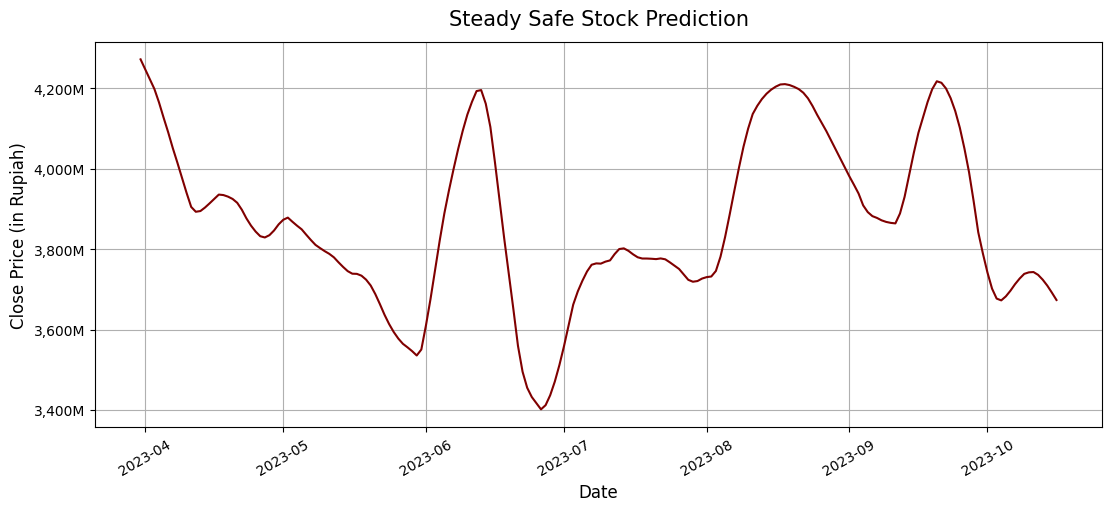

In [460]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [461]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 13s 278ms/step - loss: 0.0176 - val_loss: 0.0031
Epoch 2/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 5s 226ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 6s 244ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 6s 235ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 6/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0021 - val_loss: 0.002

In [462]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0184185
Mean Absolute Percentage Error (MAPE): 0.04551
Root Mean Squared Error (RMSE): 0.02477
Mean Squared Error (MSE): 0.0006138
R-Squared (R2): 0.391229
T-Statistic 0.9751
P-Value 0.0003400649584364146
Elapsed Time (min): 65.51


7/7 [==============================] - 0s 38ms/step


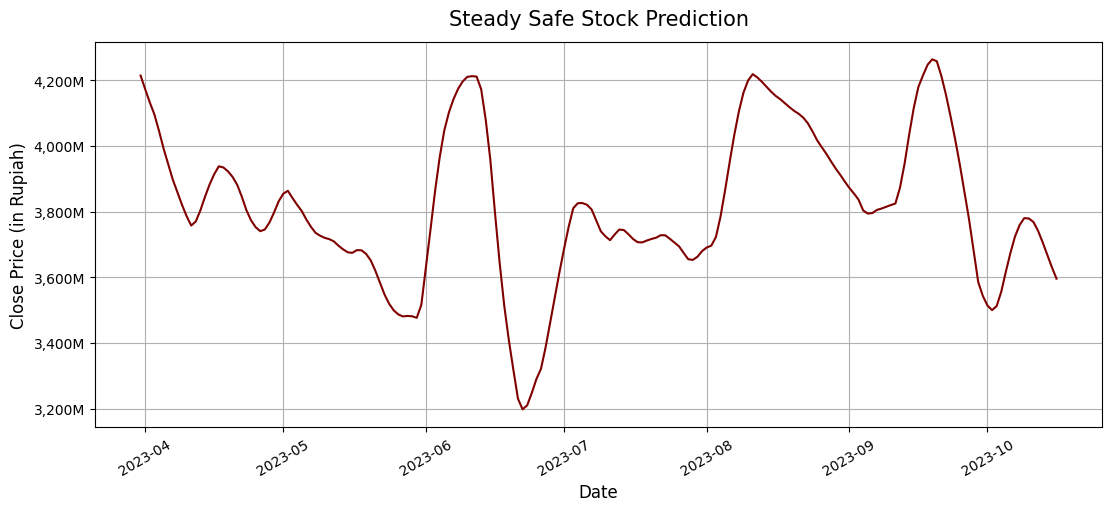

In [463]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [464]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 15s 333ms/step - loss: 0.0921 - val_loss: 0.1058
Epoch 2/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0693 - val_loss: 0.0809
Epoch 3/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0568 - val_loss: 0.0637
Epoch 4/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0485 - val_loss: 0.0513
Epoch 5/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0432 - val_loss: 0.0422
Epoch 6/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0396 - val_loss: 0.0357
Epoch 7/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0369 - val_loss: 0.0307
Epoch 8/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0347 - val_loss: 0.0269
Epoch 9/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0333 - val_loss: 0.0240
Epoch 10/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0319 - val_loss: 0.021

In [465]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.1523978
Mean Absolute Percentage Error (MAPE): 0.37608
Root Mean Squared Error (RMSE): 0.1553
Mean Squared Error (MSE): 0.0241184
R-Squared (R2): -22.919016
T-Statistic 0.9607
P-Value 4.104341314814519e-06
Elapsed Time (min): 72.3


7/7 [==============================] - 0s 39ms/step


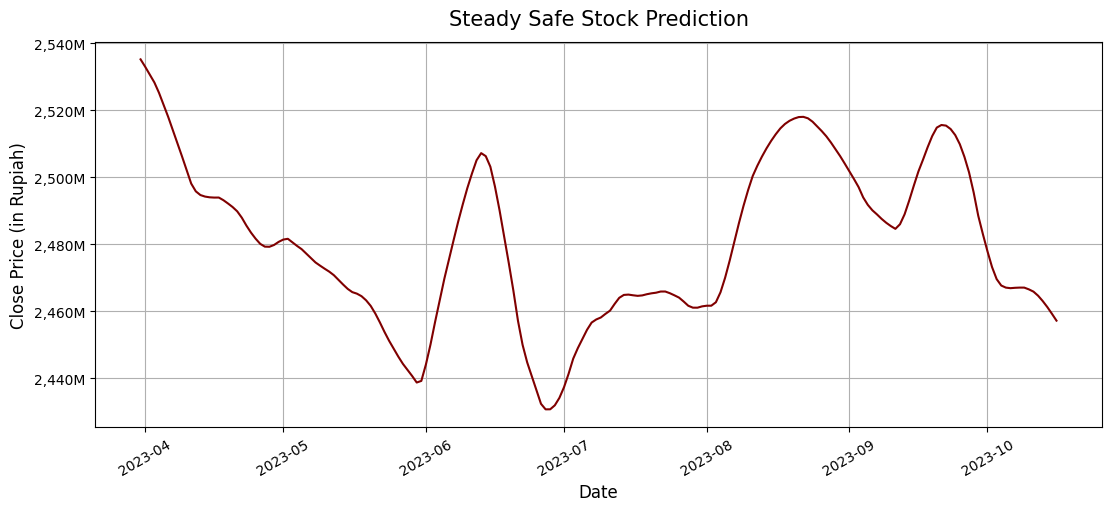

In [466]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [467]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 17s 314ms/step - loss: 0.0120 - val_loss: 0.0031
Epoch 2/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 4/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0018 - val_loss: 0.002

In [468]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.016943
Mean Absolute Percentage Error (MAPE): 0.04197
Root Mean Squared Error (RMSE): 0.0233
Mean Squared Error (MSE): 0.000543
R-Squared (R2): 0.461457
T-Statistic 0.9756
P-Value 0.0003990867407992482
Elapsed Time (min): 74.36


7/7 [==============================] - 0s 42ms/step


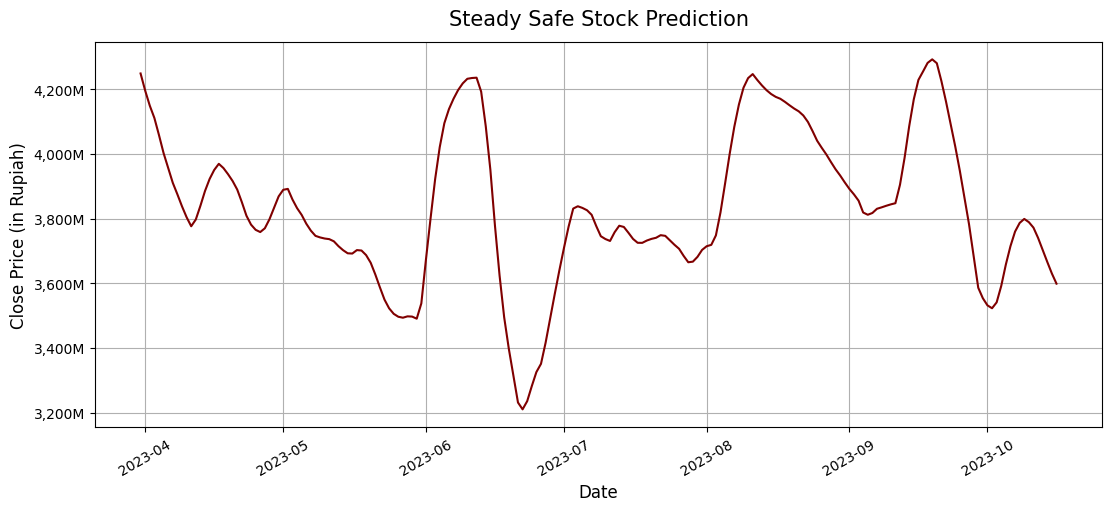

In [469]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [470]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 18s 344ms/step - loss: 0.0123 - val_loss: 0.0079
Epoch 2/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 3/10
24/24 [==============================] - 7s 295ms/step - loss: 0.0043 - val_loss: 0.0066
Epoch 4/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 5/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 7/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 9/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 10/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0027 - val_loss: 0.003

In [471]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 50ms/step
Mean Absolute Error (MAE): 0.0296531
Mean Absolute Percentage Error (MAPE): 0.07295
Root Mean Squared Error (RMSE): 0.03505
Mean Squared Error (MSE): 0.0012285
R-Squared (R2): -0.218327
T-Statistic 0.9708
P-Value 8.200842421501875e-05
Elapsed Time (min): 77.64


7/7 [==============================] - 0s 48ms/step


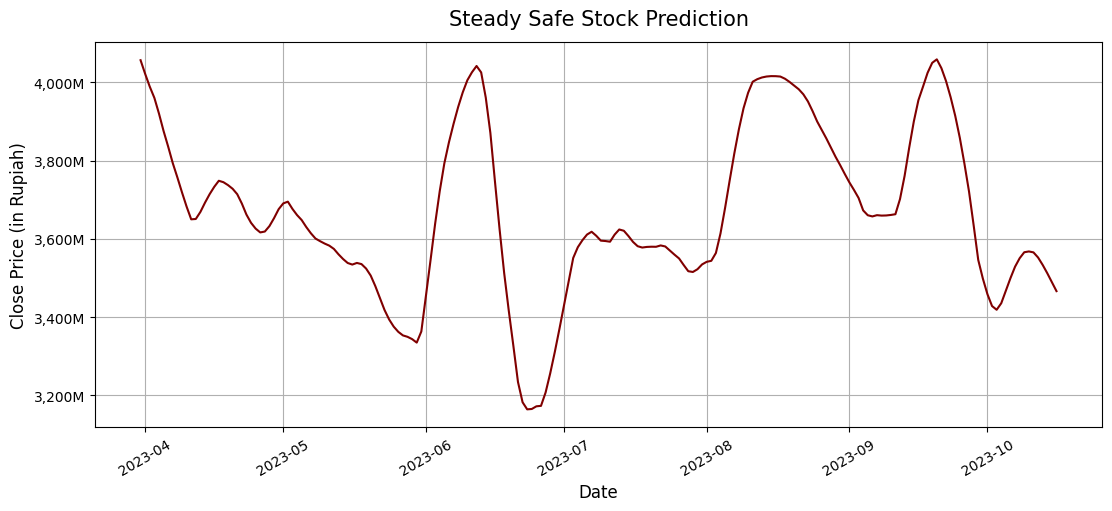

In [472]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [473]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 15s 317ms/step - loss: 0.0860 - val_loss: 0.1276
Epoch 2/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0852 - val_loss: 0.1258
Epoch 3/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0837 - val_loss: 0.1240
Epoch 4/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0824 - val_loss: 0.1221
Epoch 5/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0816 - val_loss: 0.1202
Epoch 6/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0805 - val_loss: 0.1184
Epoch 7/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0796 - val_loss: 0.1165
Epoch 8/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0780 - val_loss: 0.1146
Epoch 9/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0761 - val_loss: 0.1127
Epoch 10/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0755 - val_loss: 0.110

In [474]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.3496615
Mean Absolute Percentage Error (MAPE): 0.87044
Root Mean Squared Error (RMSE): 0.35097
Mean Squared Error (MSE): 0.1231789
R-Squared (R2): -121.160323
T-Statistic 0.9527
P-Value 5.131474267727754e-07
Elapsed Time (min): 70.21


7/7 [==============================] - 0s 58ms/step


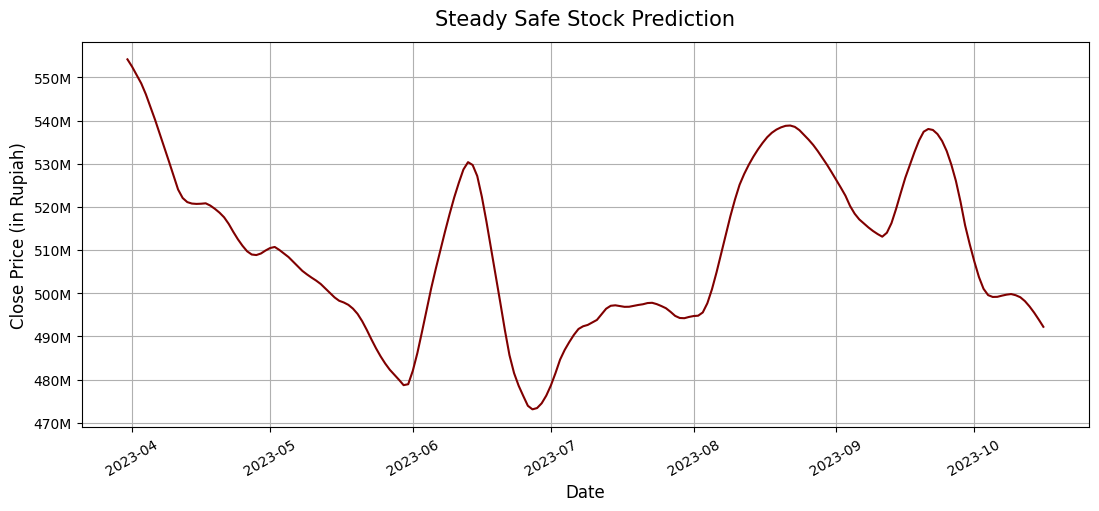

In [475]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [476]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 15s 326ms/step - loss: 0.0446 - val_loss: 0.0211
Epoch 2/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0263 - val_loss: 0.0133
Epoch 3/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0235 - val_loss: 0.0113
Epoch 4/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0211 - val_loss: 0.0110
Epoch 5/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0187 - val_loss: 0.0101
Epoch 6/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0166 - val_loss: 0.0086
Epoch 7/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0146 - val_loss: 0.0083
Epoch 8/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0124 - val_loss: 0.0072
Epoch 9/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0104 - val_loss: 0.0053
Epoch 10/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0083 - val_loss: 0.004

In [477]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0458683
Mean Absolute Percentage Error (MAPE): 0.11119
Root Mean Squared Error (RMSE): 0.05128
Mean Squared Error (MSE): 0.0026298
R-Squared (R2): -1.608041
T-Statistic 0.9542
P-Value 7.396988621621858e-07
Elapsed Time (min): 72.31


7/7 [==============================] - 0s 41ms/step


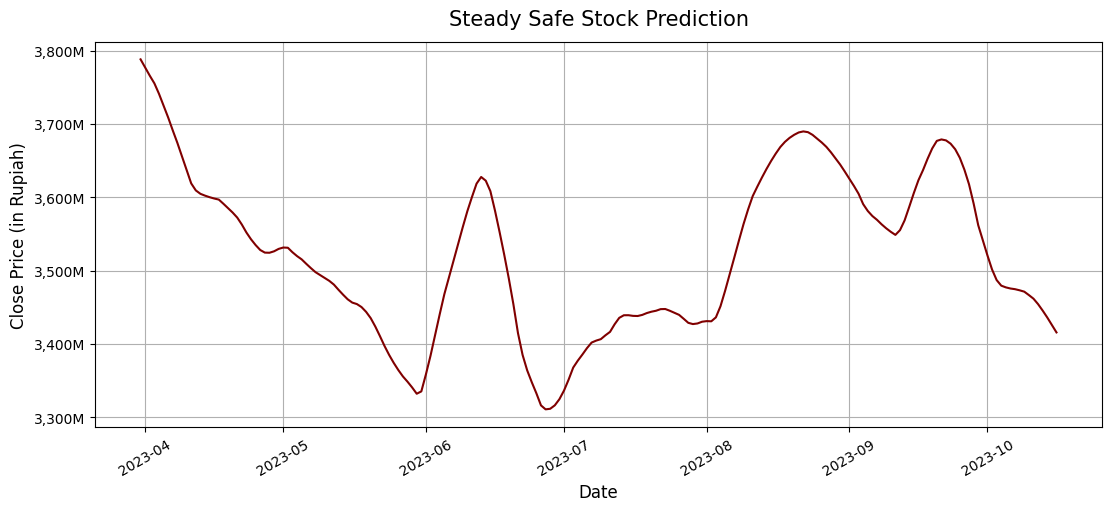

In [478]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [479]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 17s 322ms/step - loss: 0.0231 - val_loss: 0.0038
Epoch 2/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 3/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 5/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/10
24/24 [==============================] - 7s 284ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/10
24/24 [==============================] - 7s 287ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 7s 291ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 10/10
24/24 [==============================] - 7s 292ms/step - loss: 0.0030 - val_loss: 0.003

In [480]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Error (MAE): 0.0187016
Mean Absolute Percentage Error (MAPE): 0.04709
Root Mean Squared Error (RMSE): 0.02566
Mean Squared Error (MSE): 0.0006586
R-Squared (R2): 0.346848
T-Statistic 0.9665
P-Value 2.2045285732019693e-05
Elapsed Time (min): 78.57


7/7 [==============================] - 0s 45ms/step


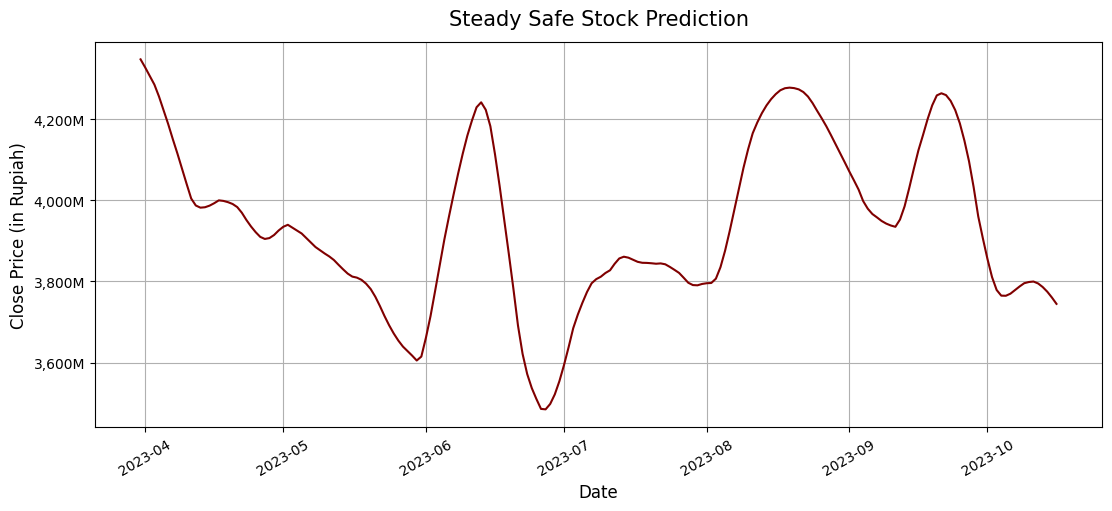

In [481]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [482]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 16s 383ms/step - loss: 0.2665 - val_loss: 0.0181
Epoch 2/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0449 - val_loss: 0.0193
Epoch 3/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0425 - val_loss: 0.0231
Epoch 4/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0338 - val_loss: 0.0119
Epoch 5/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0406 - val_loss: 0.0145
Epoch 6/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0180 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0087 - val_loss: 0.0046
Epoch 8/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0072 - val_loss: 0.0031
Epoch 9/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 10/10
24/24 [==============================] - 8s 329ms/step - loss: 0.0059 - val_loss: 0.003

In [483]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 50ms/step
Mean Absolute Error (MAE): 0.0211831
Mean Absolute Percentage Error (MAPE): 0.05229
Root Mean Squared Error (RMSE): 0.02862
Mean Squared Error (MSE): 0.0008193
R-Squared (R2): 0.187497
T-Statistic 0.9526
P-Value 4.97927999276726e-07
Elapsed Time (min): 79.59


7/7 [==============================] - 0s 44ms/step


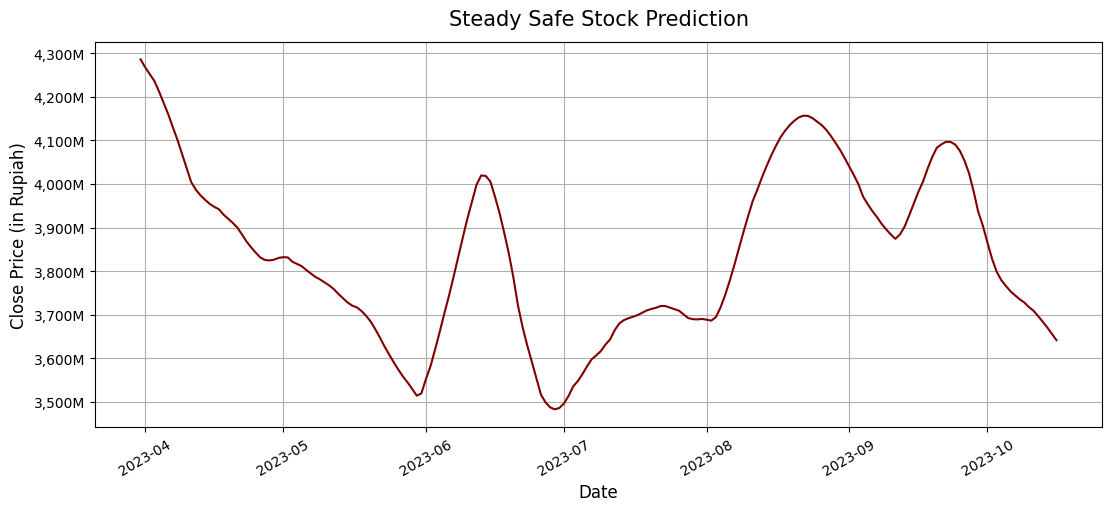

In [484]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [485]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 15s 323ms/step - loss: 0.0479 - val_loss: 0.0128
Epoch 2/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0413 - val_loss: 0.0178
Epoch 3/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0401 - val_loss: 0.0205
Epoch 4/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0398 - val_loss: 0.0217
Epoch 5/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0397 - val_loss: 0.0221
Epoch 6/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0396 - val_loss: 0.0224
Epoch 7/10
24/24 [==============================] - 7s 292ms/step - loss: 0.0394 - val_loss: 0.0226
Epoch 8/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0394 - val_loss: 0.0229
Epoch 9/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0392 - val_loss: 0.0226
Epoch 10/10
24/24 [==============================] - 7s 299ms/step - loss: 0.0391 - val_loss: 0.022

In [486]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.1581624
Mean Absolute Percentage Error (MAPE): 0.39018
Root Mean Squared Error (RMSE): 0.16128
Mean Squared Error (MSE): 0.0260116
R-Squared (R2): -24.796492
T-Statistic 0.9376
P-Value 1.60219695288788e-08
Elapsed Time (min): 76.42


7/7 [==============================] - 0s 47ms/step


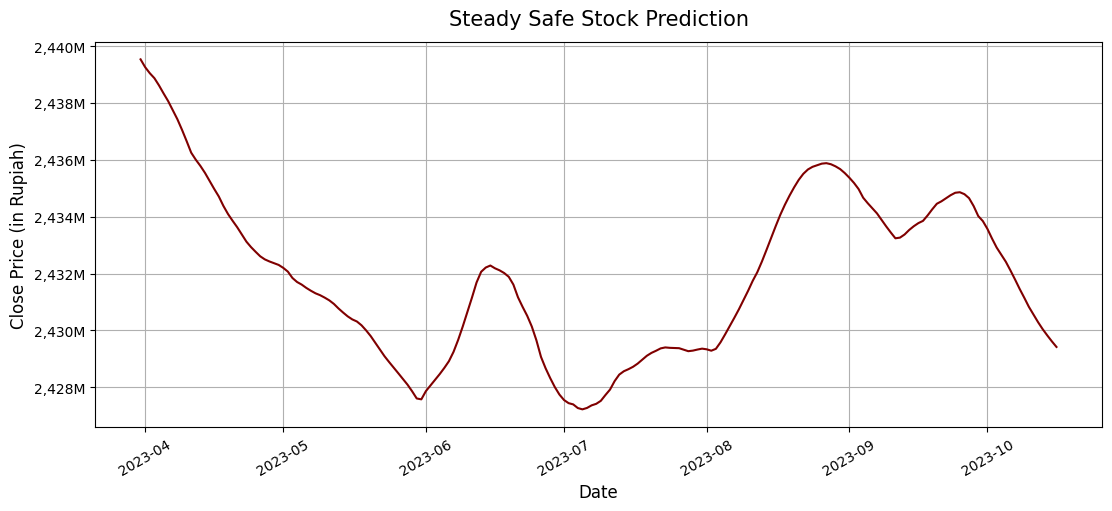

In [487]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [488]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 20s 355ms/step - loss: 0.0142 - val_loss: 0.0034
Epoch 2/10
24/24 [==============================] - 7s 292ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 3/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 7s 296ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 7s 298ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 7s 297ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 7s 292ms/step - loss: 0.0017 - val_loss: 0.002

In [489]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0163909
Mean Absolute Percentage Error (MAPE): 0.04056
Root Mean Squared Error (RMSE): 0.02255
Mean Squared Error (MSE): 0.0005087
R-Squared (R2): 0.495545
T-Statistic 0.9786
P-Value 0.0011635635746642947
Elapsed Time (min): 82.98


7/7 [==============================] - 0s 38ms/step


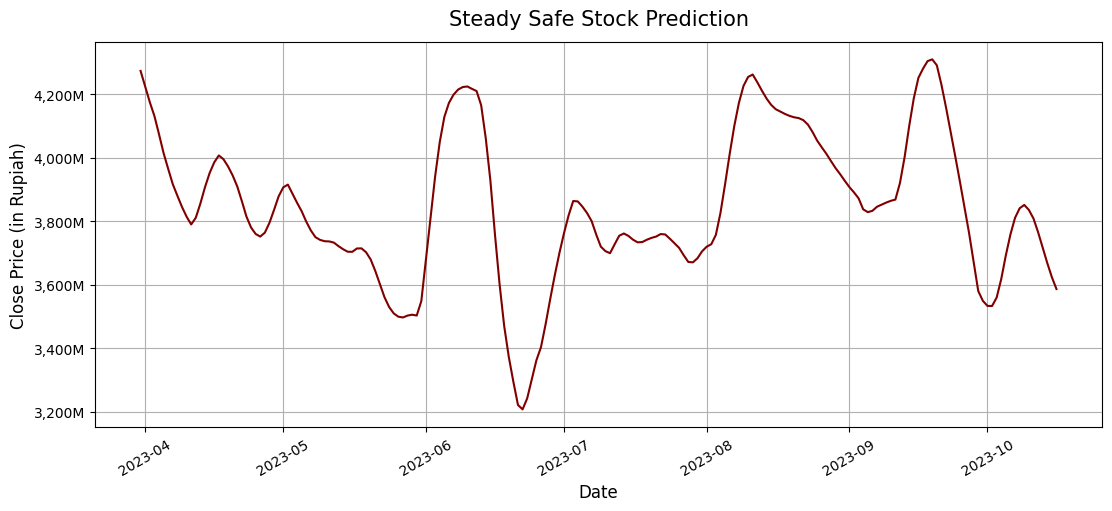

In [490]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [491]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 15s 322ms/step - loss: 0.0296 - val_loss: 0.0262
Epoch 2/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0079 - val_loss: 0.0032
Epoch 3/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0056 - val_loss: 0.0129
Epoch 4/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0053 - val_loss: 0.0119
Epoch 5/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 6/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0038 - val_loss: 0.0090
Epoch 7/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0036 - val_loss: 0.0074
Epoch 8/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 9/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 10/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0029 - val_loss: 0.003

In [492]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Error (MAE): 0.0264128
Mean Absolute Percentage Error (MAPE): 0.06493
Root Mean Squared Error (RMSE): 0.03257
Mean Squared Error (MSE): 0.0010606
R-Squared (R2): -0.051861
T-Statistic 0.9688
P-Value 4.382418774184771e-05
Elapsed Time (min): 74.82


7/7 [==============================] - 0s 40ms/step


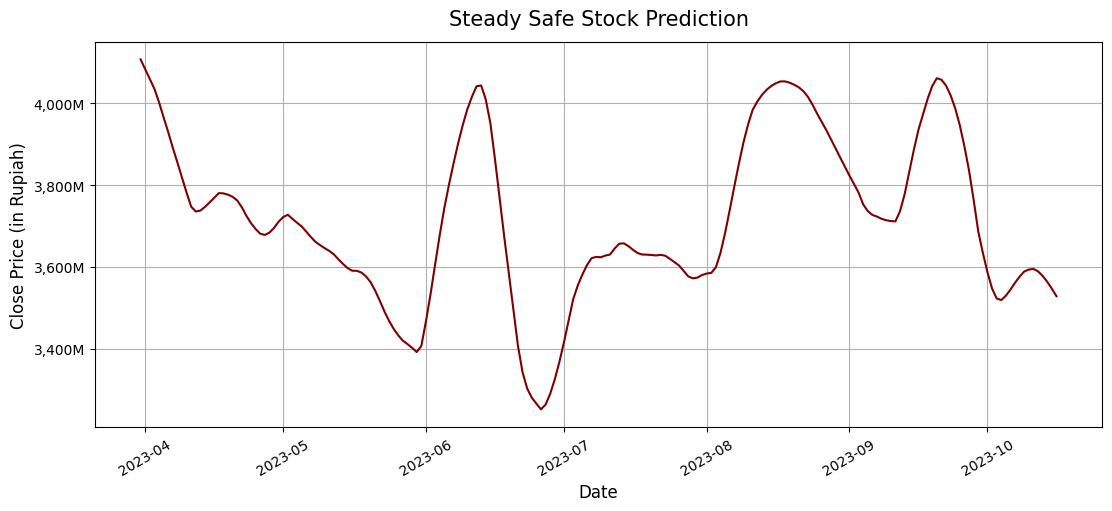

In [493]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [494]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 14s 297ms/step - loss: 0.1197 - val_loss: 0.1768
Epoch 2/10
24/24 [==============================] - 6s 240ms/step - loss: 0.1191 - val_loss: 0.1758
Epoch 3/10
24/24 [==============================] - 6s 253ms/step - loss: 0.1184 - val_loss: 0.1748
Epoch 4/10
24/24 [==============================] - 6s 254ms/step - loss: 0.1176 - val_loss: 0.1737
Epoch 5/10
24/24 [==============================] - 6s 254ms/step - loss: 0.1171 - val_loss: 0.1726
Epoch 6/10
24/24 [==============================] - 6s 257ms/step - loss: 0.1162 - val_loss: 0.1715
Epoch 7/10
24/24 [==============================] - 6s 267ms/step - loss: 0.1155 - val_loss: 0.1704
Epoch 8/10
24/24 [==============================] - 6s 262ms/step - loss: 0.1145 - val_loss: 0.1693
Epoch 9/10
24/24 [==============================] - 6s 260ms/step - loss: 0.1139 - val_loss: 0.1682
Epoch 10/10
24/24 [==============================] - 6s 259ms/step - loss: 0.1131 - val_loss: 0.167

In [495]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Error (MAE): 0.4281985
Mean Absolute Percentage Error (MAPE): 1.06717
Root Mean Squared Error (RMSE): 0.42931
Mean Squared Error (MSE): 0.1843068
R-Squared (R2): -181.782786
T-Statistic 0.9492
P-Value 2.1591451115909877e-07
Elapsed Time (min): 69.85


7/7 [==============================] - 0s 38ms/step


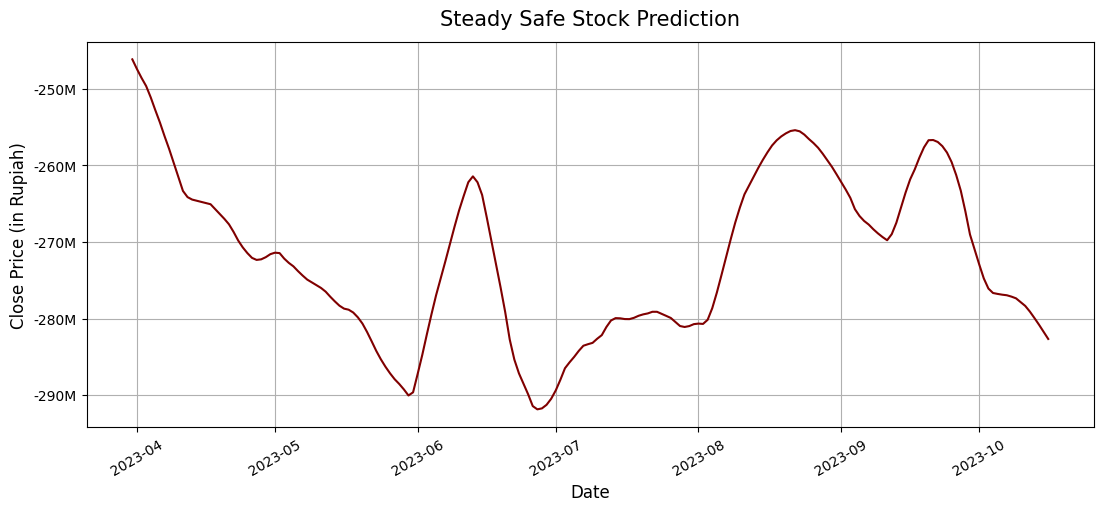

In [496]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [497]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 13s 291ms/step - loss: 0.0438 - val_loss: 0.0266
Epoch 2/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0390 - val_loss: 0.0229
Epoch 3/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0386 - val_loss: 0.0257
Epoch 4/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0384 - val_loss: 0.0197
Epoch 5/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0381 - val_loss: 0.0205
Epoch 6/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0378 - val_loss: 0.0215
Epoch 7/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0374 - val_loss: 0.0213
Epoch 8/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0371 - val_loss: 0.0226
Epoch 9/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0367 - val_loss: 0.0233
Epoch 10/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0366 - val_loss: 0.022

In [498]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 47ms/step
Mean Absolute Error (MAE): 0.157868
Mean Absolute Percentage Error (MAPE): 0.38957
Root Mean Squared Error (RMSE): 0.16087
Mean Squared Error (MSE): 0.0258794
R-Squared (R2): -24.66537
T-Statistic 0.9555
P-Value 1.0356702659919392e-06
Elapsed Time (min): 67.68


7/7 [==============================] - 0s 45ms/step


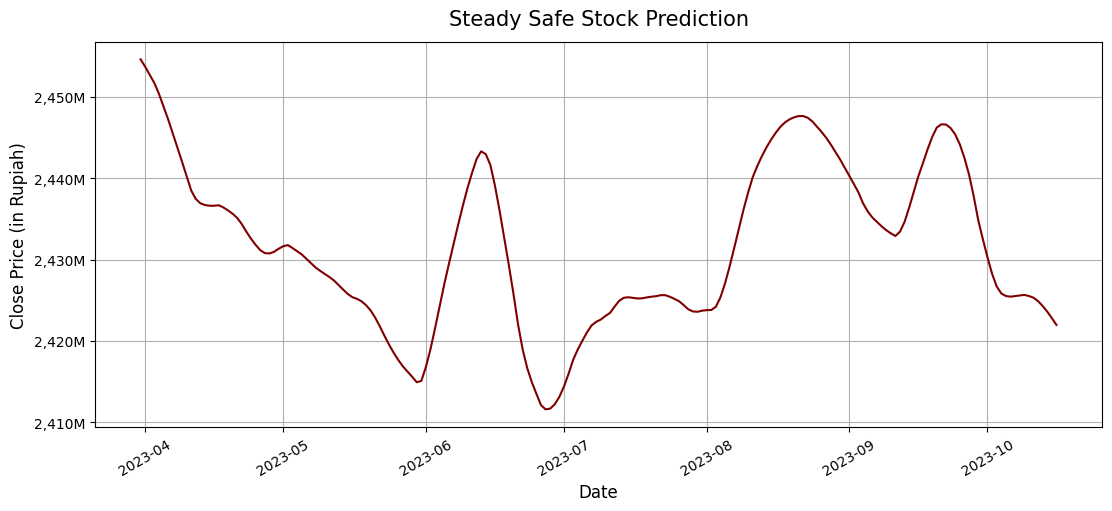

In [499]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [500]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 15s 349ms/step - loss: 0.8758 - val_loss: 0.0115
Epoch 2/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0556 - val_loss: 0.0145
Epoch 3/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0495 - val_loss: 0.0224
Epoch 4/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0473 - val_loss: 0.0181
Epoch 5/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0455 - val_loss: 0.0172
Epoch 6/10
24/24 [==============================] - 7s 297ms/step - loss: 0.0394 - val_loss: 0.0100
Epoch 7/10
24/24 [==============================] - 9s 361ms/step - loss: 0.0297 - val_loss: 0.0054
Epoch 8/10
24/24 [==============================] - 9s 385ms/step - loss: 0.0223 - val_loss: 0.0067
Epoch 9/10
24/24 [==============================] - 9s 387ms/step - loss: 0.0196 - val_loss: 0.0059
Epoch 10/10
24/24 [==============================] - 9s 365ms/step - loss: 0.0166 - val_loss: 0.005

In [501]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 49ms/step
Mean Absolute Error (MAE): 0.0346803
Mean Absolute Percentage Error (MAPE): 0.08257
Root Mean Squared Error (RMSE): 0.04358
Mean Squared Error (MSE): 0.0018996
R-Squared (R2): -0.883877
T-Statistic 0.967
P-Value 2.5605873815948144e-05
Elapsed Time (min): 85.06


7/7 [==============================] - 0s 51ms/step


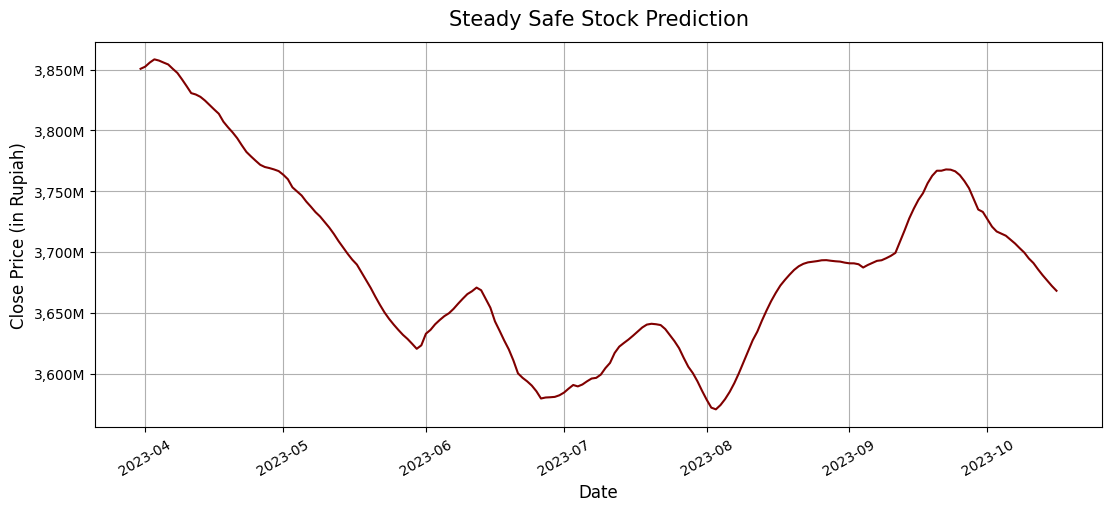

In [502]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [503]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 24s 561ms/step - loss: 0.0155 - val_loss: 0.0030
Epoch 2/10
24/24 [==============================] - 9s 392ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 3/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 4/10
24/24 [==============================] - 8s 342ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 5/10
24/24 [==============================] - 8s 319ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 7s 313ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 8s 355ms/step - loss: 0.0018 - val_loss: 0.002

In [504]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 6s 73ms/step
Mean Absolute Error (MAE): 0.0160239
Mean Absolute Percentage Error (MAPE): 0.03985
Root Mean Squared Error (RMSE): 0.02256
Mean Squared Error (MSE): 0.0005089
R-Squared (R2): 0.495301
T-Statistic 0.9752
P-Value 0.0003484443877823651
Elapsed Time (min): 100.28


7/7 [==============================] - 1s 75ms/step


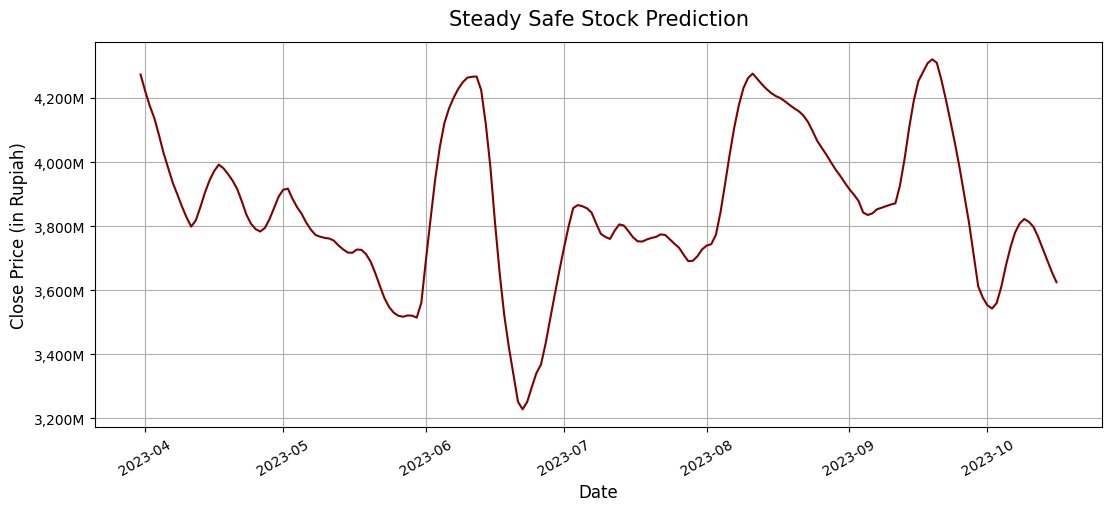

In [505]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [506]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 25s 523ms/step - loss: 0.0581 - val_loss: 0.0547
Epoch 2/10
24/24 [==============================] - 12s 510ms/step - loss: 0.0366 - val_loss: 0.0324
Epoch 3/10
24/24 [==============================] - 10s 395ms/step - loss: 0.0294 - val_loss: 0.0224
Epoch 4/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0267 - val_loss: 0.0173
Epoch 5/10
24/24 [==============================] - 7s 308ms/step - loss: 0.0244 - val_loss: 0.0147
Epoch 6/10
24/24 [==============================] - 8s 326ms/step - loss: 0.0235 - val_loss: 0.0130
Epoch 7/10
24/24 [==============================] - 8s 350ms/step - loss: 0.0221 - val_loss: 0.0119
Epoch 8/10
24/24 [==============================] - 9s 375ms/step - loss: 0.0209 - val_loss: 0.0114
Epoch 9/10
24/24 [==============================] - 9s 372ms/step - loss: 0.0196 - val_loss: 0.0108
Epoch 10/10
24/24 [==============================] - 9s 372ms/step - loss: 0.0193 - val_loss: 0.0

In [507]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 57ms/step
Mean Absolute Error (MAE): 0.0945184
Mean Absolute Percentage Error (MAPE): 0.23162
Root Mean Squared Error (RMSE): 0.09843
Mean Squared Error (MSE): 0.0096887
R-Squared (R2): -8.608627
T-Statistic 0.9515
P-Value 3.8050936268518853e-07
Elapsed Time (min): 107.67


7/7 [==============================] - 0s 51ms/step


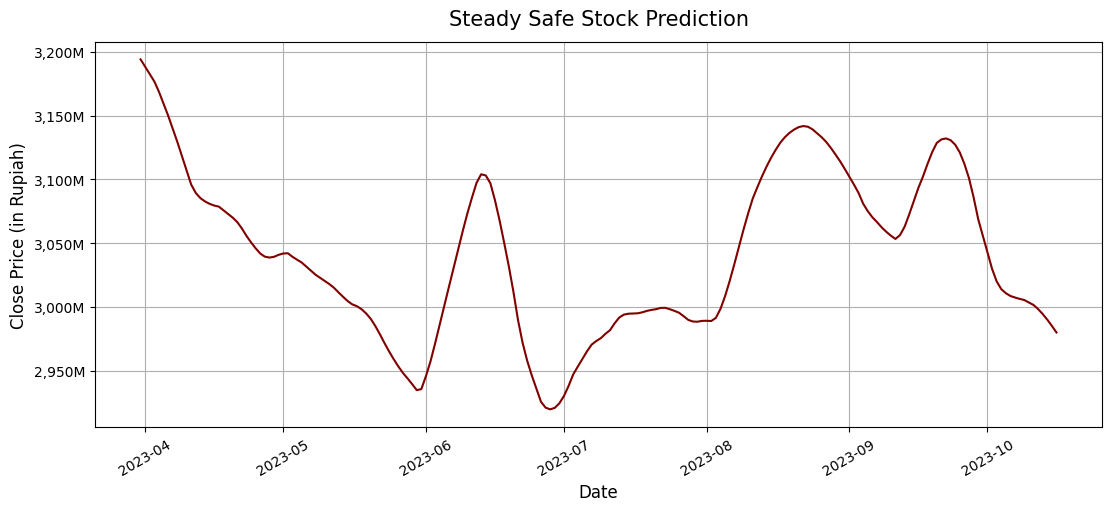

In [508]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [509]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 21s 419ms/step - loss: 0.0095 - val_loss: 0.0034
Epoch 2/10
24/24 [==============================] - 8s 330ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 3/10
24/24 [==============================] - 8s 312ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 4/10
24/24 [==============================] - 7s 288ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 5/10
24/24 [==============================] - 7s 293ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 7s 302ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 8/10
24/24 [==============================] - 7s 290ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0018 - val_loss: 0.002

In [510]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 46ms/step
Mean Absolute Error (MAE): 0.0158117
Mean Absolute Percentage Error (MAPE): 0.03984
Root Mean Squared Error (RMSE): 0.02158
Mean Squared Error (MSE): 0.0004659
R-Squared (R2): 0.537937
T-Statistic 0.9761
P-Value 0.00048272241838276386
Elapsed Time (min): 87.06


7/7 [==============================] - 0s 49ms/step


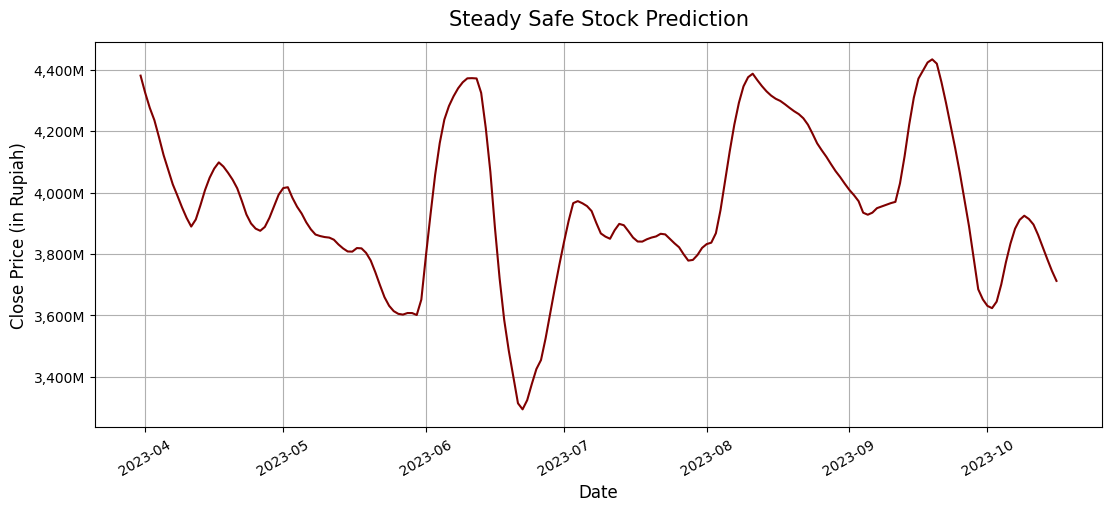

In [511]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [512]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 15s 339ms/step - loss: 0.0109 - val_loss: 0.0056
Epoch 2/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 3/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 5/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 6/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 7/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 7s 284ms/step - loss: 0.0022 - val_loss: 0.004

In [513]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0395254
Mean Absolute Percentage Error (MAPE): 0.09723
Root Mean Squared Error (RMSE): 0.044
Mean Squared Error (MSE): 0.0019361
R-Squared (R2): -0.920052
T-Statistic 0.9729
P-Value 0.00016212226182688028
Elapsed Time (min): 76.88


7/7 [==============================] - 0s 48ms/step


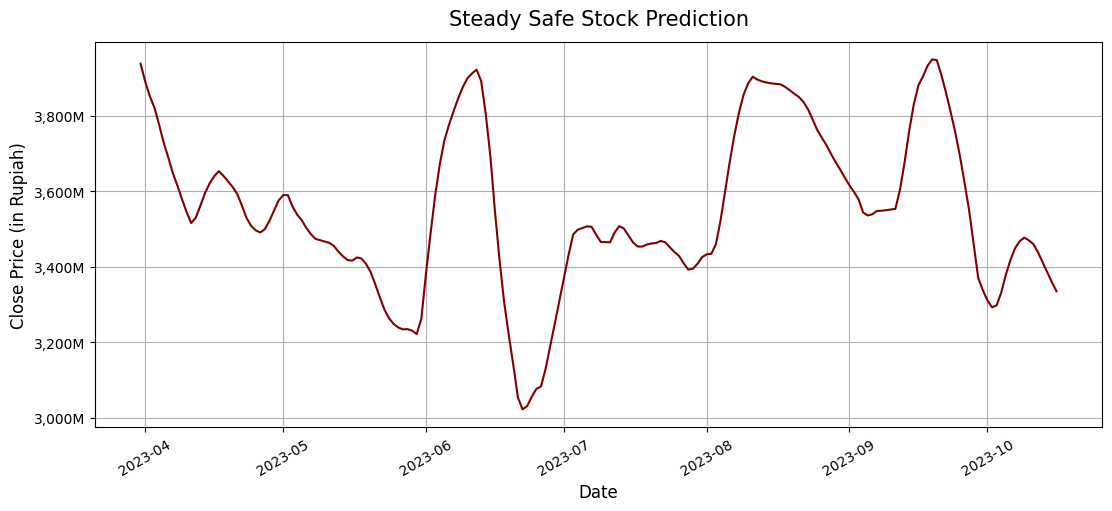

In [514]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [515]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 15s 318ms/step - loss: 0.0851 - val_loss: 0.1240
Epoch 2/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0836 - val_loss: 0.1215
Epoch 3/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0815 - val_loss: 0.1190
Epoch 4/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0802 - val_loss: 0.1165
Epoch 5/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0781 - val_loss: 0.1139
Epoch 6/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0768 - val_loss: 0.1114
Epoch 7/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0750 - val_loss: 0.1088
Epoch 8/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0729 - val_loss: 0.1063
Epoch 9/10
24/24 [==============================] - 7s 291ms/step - loss: 0.0714 - val_loss: 0.1038
Epoch 10/10
24/24 [==============================] - 7s 290ms/step - loss: 0.0698 - val_loss: 0.101

In [516]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.3340162
Mean Absolute Percentage Error (MAPE): 0.83136
Root Mean Squared Error (RMSE): 0.33533
Mean Squared Error (MSE): 0.1124454
R-Squared (R2): -110.515619
T-Statistic 0.9529
P-Value 5.401592488851747e-07
Elapsed Time (min): 76.08


7/7 [==============================] - 0s 46ms/step


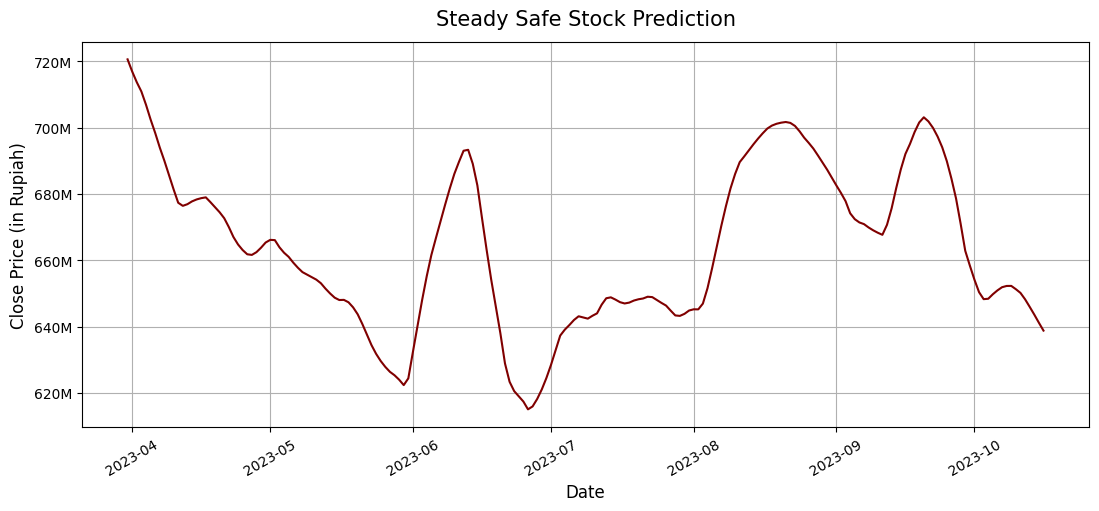

In [517]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [518]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 15s 335ms/step - loss: 0.0538 - val_loss: 0.0212
Epoch 2/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0360 - val_loss: 0.0174
Epoch 3/10
24/24 [==============================] - 8s 325ms/step - loss: 0.0301 - val_loss: 0.0149
Epoch 4/10
24/24 [==============================] - 7s 295ms/step - loss: 0.0249 - val_loss: 0.0135
Epoch 5/10
24/24 [==============================] - 9s 373ms/step - loss: 0.0206 - val_loss: 0.0105
Epoch 6/10
24/24 [==============================] - 8s 320ms/step - loss: 0.0167 - val_loss: 0.0092
Epoch 7/10
24/24 [==============================] - 9s 377ms/step - loss: 0.0133 - val_loss: 0.0071
Epoch 8/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0107 - val_loss: 0.0059
Epoch 9/10
24/24 [==============================] - 7s 308ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 10/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0071 - val_loss: 0.00

In [519]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 42ms/step
Mean Absolute Error (MAE): 0.0406081
Mean Absolute Percentage Error (MAPE): 0.09852
Root Mean Squared Error (RMSE): 0.04631
Mean Squared Error (MSE): 0.0021445
R-Squared (R2): -1.12678
T-Statistic 0.9536
P-Value 6.356854669320455e-07
Elapsed Time (min): 87.56


7/7 [==============================] - 0s 46ms/step


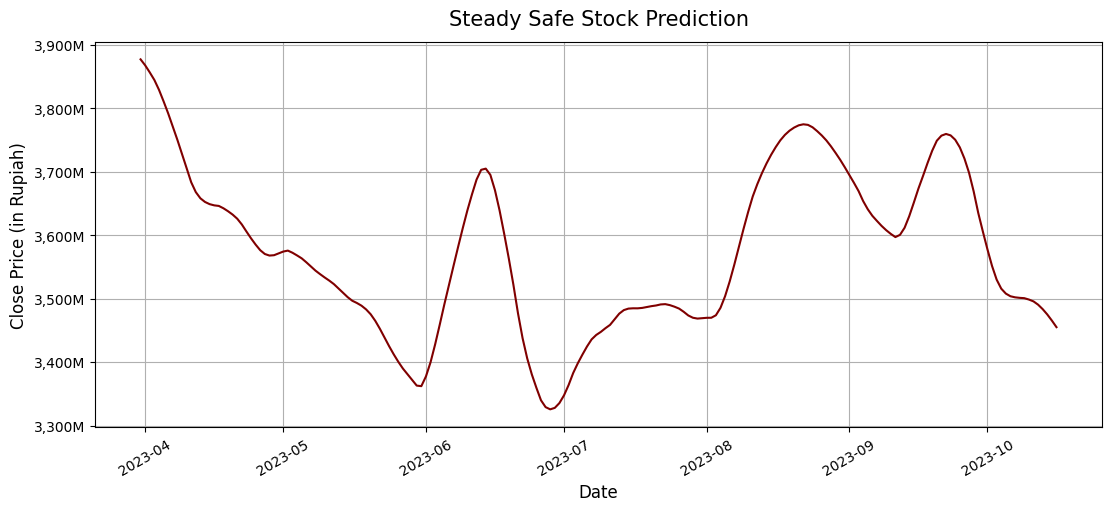

In [520]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [521]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 15s 325ms/step - loss: 0.0139 - val_loss: 0.0036
Epoch 2/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 3/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 7/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 8/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0024 - val_loss: 0.002

In [522]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0183708
Mean Absolute Percentage Error (MAPE): 0.0464
Root Mean Squared Error (RMSE): 0.02544
Mean Squared Error (MSE): 0.0006471
R-Squared (R2): 0.358257
T-Statistic 0.9684
P-Value 3.8659196434309706e-05
Elapsed Time (min): 75.47


7/7 [==============================] - 0s 40ms/step


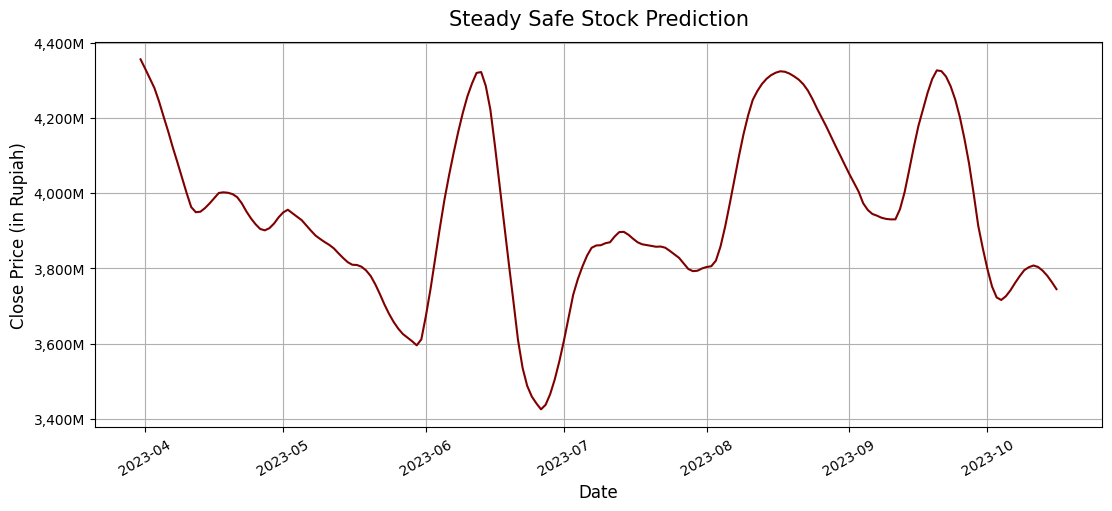

In [523]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [524]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
import time
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 46ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 41ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 45ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 38ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 51ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 39ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 38ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 45ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 41ms/step
Training

In [525]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                73.45  0.33524   0.83432  0.11329   
           adagrad                 84.59  0.09998   0.24519  0.01078   
           adam                    73.42  0.01733   0.04394  0.00051   
           adamax                  73.16  0.02190   0.05607  0.00079   
           nadam                   75.10  0.01868   0.04745  0.00058   
           rmsprop                 73.65  0.04833   0.11920  0.00274   
           sgd                     74.07  0.04738   0.11485  0.00282   
relu       adadelta                86.49  0.39505   0.98391  0.15708   
           adagrad                 70.46  0.13840   0.34125  0.01998   
           adam                    71.56  0.03749   0.09214  0.00178   
           adamax                 106.56  0.01858   0.04628  0.00067   
           nadam                   85.59  0.01579   0.03962  0.00049   
           rmsprop                 91.94  0.02933   0.07208  0.00121   
           sgd                     98.82  0.05622   0.13668  0.00377   
sigmoid    adadelta                83.88  1.53019   3.82916  2.34249   
           adagrad                 73.15  0.19198   0.47498  0.03784   
           adam                    76.94  0.04120   0.10748  0.00228   
           adamax                  82.65  0.02677   0.06428  0.00121   
           nadam                   83.38  0.04802   0.12237  0.00294   
           rmsprop                 83.07  0.04617   0.11842  0.00266   
           sgd                     79.51  0.14531   0.35807  0.02208   
tanh       adadelta                85.23  0.41482   1.03318  0.17319   
           adagrad                 88.97  0.11079   0.27220  0.01307   
           adam                    84.30  0.01733   0.04402  0.00050   
           adamax                  73.62  0.01930   0.04920  0.00066   
           nadam                   91.41  0.01590   0.03997  0.00048   
           rmsprop                 83.29  0.02478   0.06105  0.00093   
           sgd                     77.46  0.05295   0.12872  0.00337   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   1.111781e-07        -111.35   0.33659     0.946368  
           adagrad    4.250462e-07          -9.69   0.10383     0.951971  
           adam       3.915612e-04           0.49   0.02258     0.975527  
           adamax     3.494194e-05           0.21   0.02811     0.968060  
           nadam      3.704528e-04           0.43   0.02408     0.975365  
           rmsprop    1.414400e-04          -1.72   0.05235     0.972486  
           sgd        6.734839e-08          -1.80   0.05310     0.944182  
relu       adadelta   1.659857e-04        -154.78   0.39633     0.972974  
           adagrad    1.812984e-06         -18.81   0.14135     0.957645  
           adam       1.823945e-04          -0.77   0.04219     0.973259  
           adamax     2.794361e-05           0.34   0.02588     0.967324  
           nadam      4.295490e-04           0.51   0.02214     0.975796  
           rmsprop    8.194555e-05          -0.20   0.03479     0.970794  
           sgd        1.317589e-07          -2.74   0.06140     0.947098  
sigmoid    adadelta   3.611516e-05       -2322.12   1.53052     0.968168  
           adagrad    8.337770e-05         -36.53   0.19453     0.970848  
           adam       5.003841e-08          -1.26   0.04775     0.942862  
           adamax     2.226768e-08          -0.20   0.03479     0.939172  
           nadam      6.014928e-05          -1.92   0.05422     0.969815  
           rmsprop    2.727562e-05          -1.64   0.05158     0.967244  
           sgd        7.154989e-06         -20.90   0.14859     0.962663  
tanh       adadelta   4.119127e-05        -170.76   0.41616     0.968597  
           adagrad    4.149345e-07         -11.96   0.11432  

In [526]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

,,Elapsed Time (min),MAE (%),MAPE (%),MSE (%),P-Value,R-Squared (%),RMSE (%),T-Statistic
Activation,Optimizer,,,,,,,,
relu,nadam,85.59,0.01579,0.03962,0.00049,4.295490e-04,0.51,0.02214,0.975796
tanh,nadam,91.41,0.01590,0.03997,0.00048,5.620778e-04,0.53,0.02191,0.976571
linear,adam,73.42,0.01733,0.04394,0.00051,3.915612e-04,0.49,0.02258,0.975527
tanh,adam,84.30,0.01733,0.04402,0.00050,4.891953e-04,0.50,0.02236,0.976172
relu,adamax,106.56,0.01858,0.04628,0.00067,2.794361e-05,0.34,0.02588,0.967324
linear,nadam,75.10,0.01868,0.04745,0.00058,3.704528e-04,0.43,0.02408,0.975365
tanh,adamax,73.62,0.01930,0.04920,0.00066,3.240719e-05,0.34,0.02569,0.967813
linear,adamax,73.16,0.02190,0.05607,0.00079,3.494194e-05,0.21,0.02811,0.968060
tanh,rmsprop,83.29,0.02478,0.06105,0.00093,1.188971e-04,0.08,0.03050,0.971952


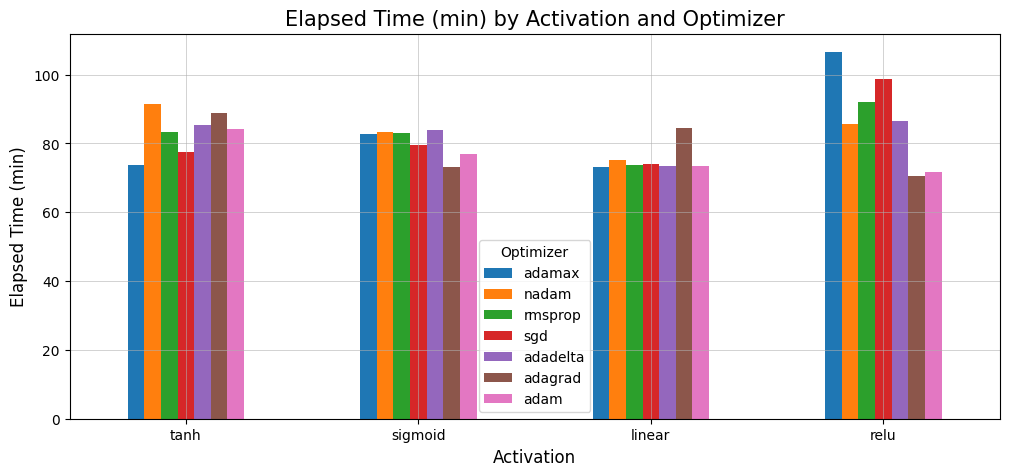

In [527]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

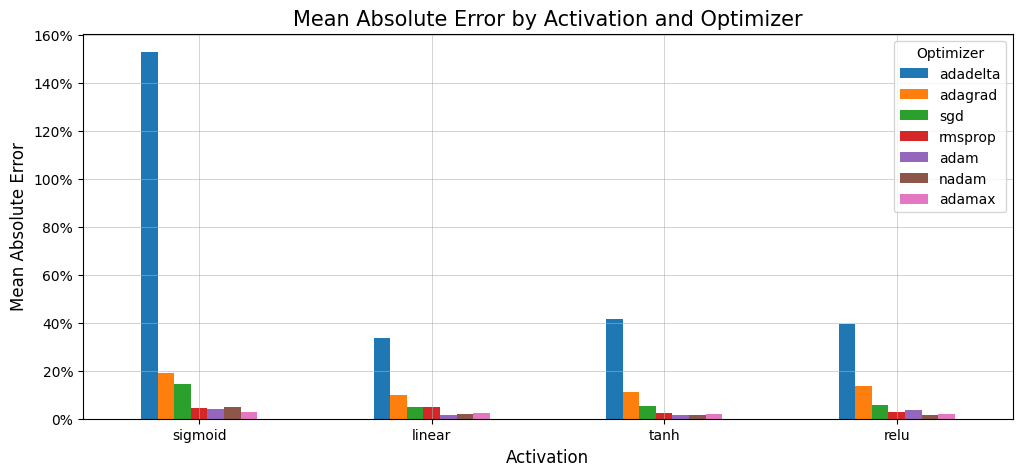

In [528]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

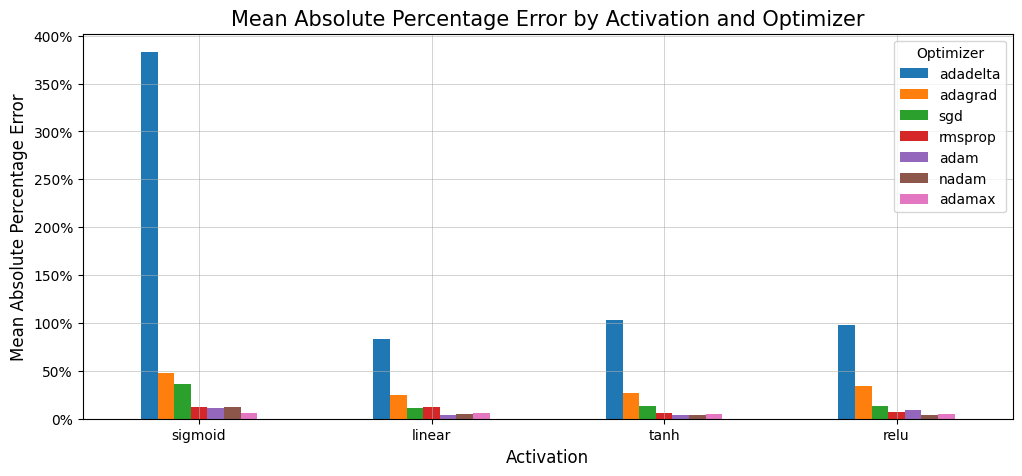

In [529]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

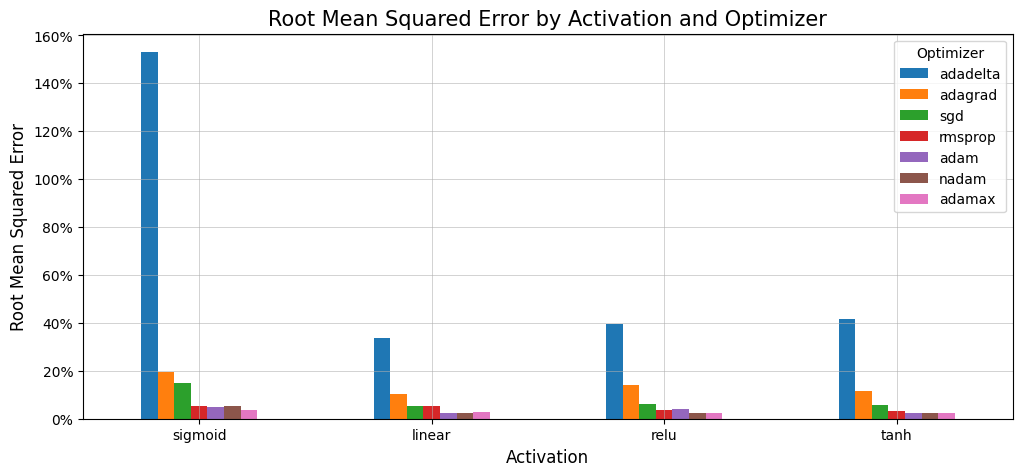

In [530]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

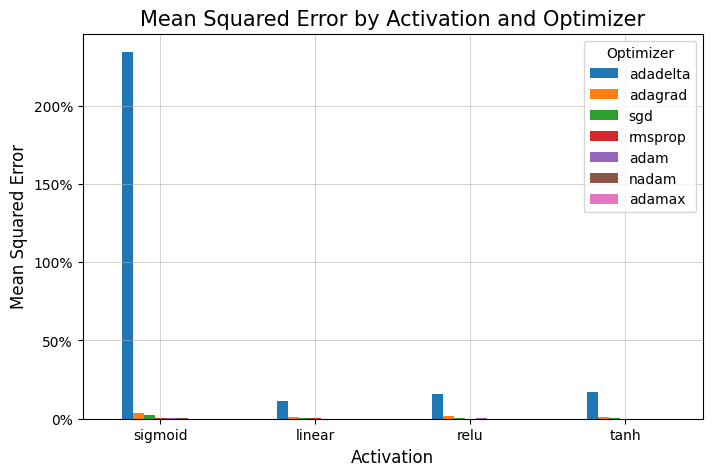

In [533]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=False)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

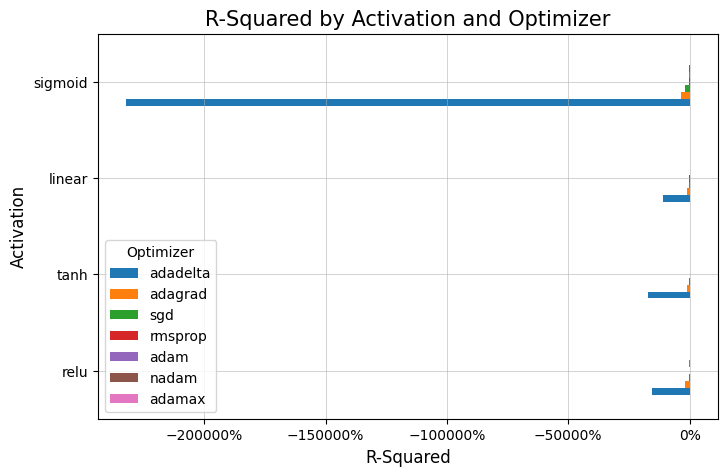

In [532]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()